<a href="https://colab.research.google.com/github/acdc-digital/acdc.cooksite/blob/master/colab_files/%20finsolo_v_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to FinSolo.

next steps:

download the transaction for the the past year + 2. Ie; all of 2021, 2022, and up to date this year. We'll manually format the CSV's given it's easy to upload all them all into Airtable, and then modify the rows. Then once your [db] is setup you can export the entire csv, now combining all the financial records.

### Welcome.

This is your personal finance review team. You need to begin with your .csv from the institutions of your choice. This is purely a spending review & analysis. The objective is not necessarily a deep-dive into the types of transactions as specific integers, rather, this (df) represents the sentiment [good, neutral, bad] as per the transaction type's description. Then we analyze the tokenized and embedded data to determine where spending occurs most frequently in each category.

We've pulled some good textual references. Mostly related to clustering habits. I wanted maybe more reference to an expansive list. I think we've generated some solid text and visualize references to use the generated data, and implement a solid reference guide for our Airtable cost analysis.

#### install dependencies & and statements

import csv analysis

In [ ]:
! pip install matplotlib
! pip install nltk
! pip install pandas
! pip install scikit-learn
! pip install torch
! pip install transformers
! pip install wordcloud
! pip install tqdm

import csv analysis

In [ ]:
import os
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import torch
from collections import Counter
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer, GPT2TokenizerFast
from wordcloud import WordCloud

#### upload institutions .csv/ tokenize/ convert to [df] ans save to fin_data_tokens

In [ ]:
# Download the Punkt tokenizer models for tokenization
nltk.download('punkt')

In [ ]:
# Step 1: Read the existing CSV file into a DataFrame
# Replace 'your_existing_file.csv' with the path to your existing CSV file
existing_csv_path = '/content/fin_data/master-cheq-AT.YNAB2.csv'
df = pd.read_csv(existing_csv_path, usecols=['Date', 'Payee', 'Memo', 'Outflow', 'Inflow'])

# Step 2: Tokenize the 'Payee' column and add it as a new 'Tokens' column
df['Tokens'] = df['Payee'].apply(word_tokenize)

# Step 3: Display the first few rows to verify
print(df.head())

# Step 4: Create the output directory if it doesn't exist
output_directory = '/content/fin_data_tokens'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Step 5: Export the updated DataFrame to a new CSV file
output_csv_path = os.path.join(output_directory, 'fin_tokens.csv')
df.to_csv(output_csv_path, index=False)

print(f"Updated DataFrame has been saved to {output_csv_path}")

         Date                                              Payee  Memo  \
0  2023-09-11    Internet Banking INTERNET TRANSFER 000000234584   NaN   
1  2023-09-11  Point of Sale - Visa Debit VISA DEBIT RETAIL P...   NaN   
2  2023-09-11  Point of Sale - Visa Debit VISA DEBIT RETAIL P...   NaN   
3  2023-09-11  Point of Sale - Visa Debit VISA DEBIT RETAIL P...   NaN   
4  2023-09-11    Internet Banking INTERNET TRANSFER 000000203266   NaN   

  Outflow Inflow                                             Tokens  
0  $30.00    NaN  [Internet, Banking, INTERNET, TRANSFER, 000000...  
1  $15.48    NaN  [Point, of, Sale, -, Visa, Debit, VISA, DEBIT,...  
2  $11.49    NaN  [Point, of, Sale, -, Visa, Debit, VISA, DEBIT,...  
3  $13.22    NaN  [Point, of, Sale, -, Visa, Debit, VISA, DEBIT,...  
4  $70.00    NaN  [Internet, Banking, INTERNET, TRANSFER, 000000...  
Updated DataFrame has been saved to /content/fin_data_tokens/fin_tokens.csv


In [ ]:
print(df.columns)

Index(['Date', 'Payee', 'Memo', 'Outflow', 'Inflow', 'Tokens'], dtype='object')


#### fetch tokenized data for categorical analysis. This could benefit in determining spending habits, likely betterso than the embedding sentiment

Top 50 Categories:
[('Electronic Funds Transfer PREAUTHORIZED DEBIT PAYPAL', 4126), ('Electronic Funds Transfer DEPOSIT MEDAVIE BLUE CROSS', 1181), ('Electronic Funds Transfer DEPOSIT CANADA', 1014), ('Electronic Funds Transfer PREAUTHORIZED DEBIT 000000000000000 BANK OF MONTREAL', 520), ('Branch Transaction OVER LIMIT FEE', 488), ('Branch Transaction EFT DEBIT REVERSAL 000000000000000 BANK OF MONTREAL', 447), ('Branch Transaction OVERDRAFT INTEREST CHARGE', 440), ('Branch Transaction MONTHLY FIXED OVERDRAFT FEE', 395), ('Point of Sale - Interac RETAIL PURCHASE 307812131291 MUNICIPALITY OF', 383), ('Point of Sale - Interac RETAIL PURCHASE 311816042272 JOLLYTAILS', 381), ('Point of Sale - Interac RETAIL PURCHASE 305816416524 JOLLYTAILS', 378), ('Point of Sale - Interac RETAIL PURCHASE 302212417497 JOLLYTAILS', 378), ('Point of Sale - Interac RETAIL PURCHASE 324416758934 JOLLYTAILS', 374), ('Point of Sale - Interac RETAIL PURCHASE 302619946515 JOLLYTAILS', 373), ('Point of Sale - Interac

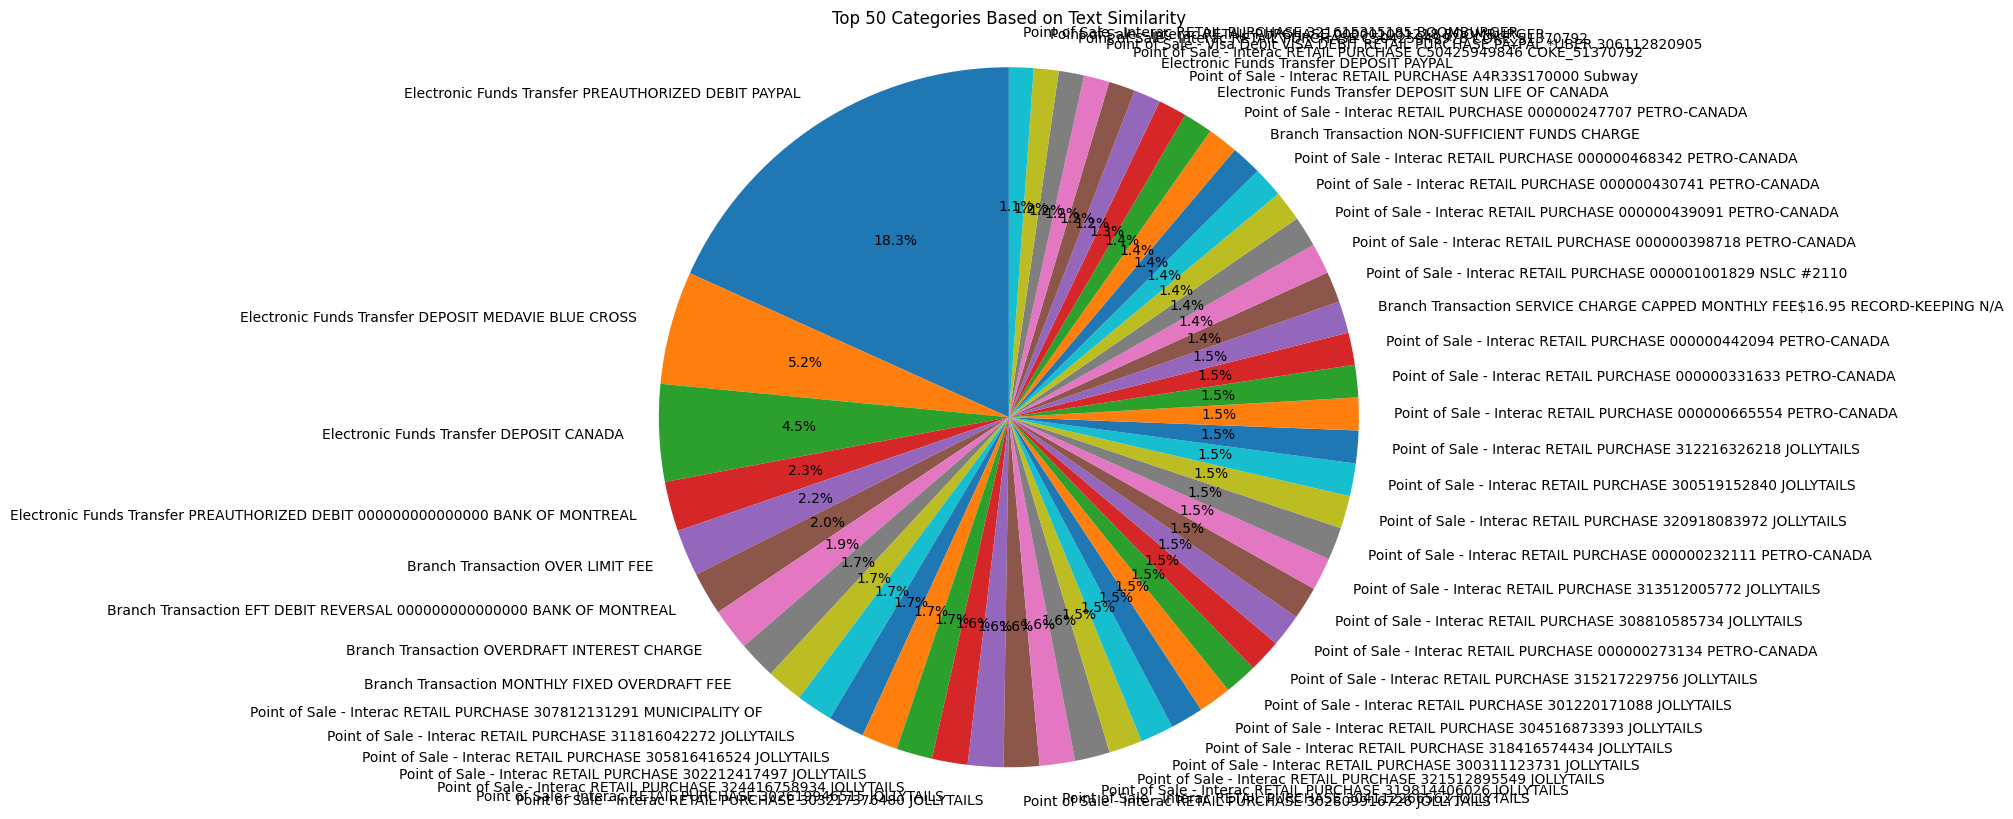

Top 50 categories have been saved to /content/fin_data_semantics/fin_data_semantics.csv


In [ ]:
# Step 1: Read the existing CSV file into a DataFrame
existing_csv_path = '/content/fin_data_tokens/fin_tokens.csv'
df = pd.read_csv(existing_csv_path)

# Step 2: Tokenize the 'Payee' column and add it as a new 'Tokens' column
df['Tokens'] = df['Payee'].apply(word_tokenize)

# Step 3: Filter out unwanted rows
df_filtered = df[~df['Payee'].str.contains('transfers|Internet Banking INTERNET TRANSFER', case=False, na=False)].reset_index(drop=True)

# Step 4: TF-IDF Vectorization
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_filtered['Payee'])

# Step 5: Compute Cosine Similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Step 6: Group duplicate and semantically similar words
categories_counter = Counter()

for idx, row in df_filtered.iterrows():
    similar_indices = cosine_sim[idx].argsort()[:-51:-1]
    similar_items = [df_filtered.iloc[i]['Payee'] for i in similar_indices]
    categories_counter.update(similar_items)

# Step 7: Get the top 50 categories
top_50_categories = categories_counter.most_common(50)
print("Top 50 Categories:")
print(top_50_categories)

# Step 8: Create the output directory if it doesn't exist
output_directory = '/content/fin_data_semantics'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Step 9: Export the top 50 categories to a new CSV file
output_csv_path = os.path.join(output_directory, 'fin_data_semantics.csv')
top_50_df = pd.DataFrame(top_50_categories, columns=['Category', 'Frequency'])
top_50_df.to_csv(output_csv_path, index=False)

# Step 10: Visualize the top 50 categories using Matplotlib
labels = [item[0] for item in top_50_categories]
sizes = [item[1] for item in top_50_categories]

plt.figure(figsize=(15, 10))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Top 50 Categories Based on Text Similarity')
plt.show()

print(f"Top 50 categories have been saved to {output_csv_path}")

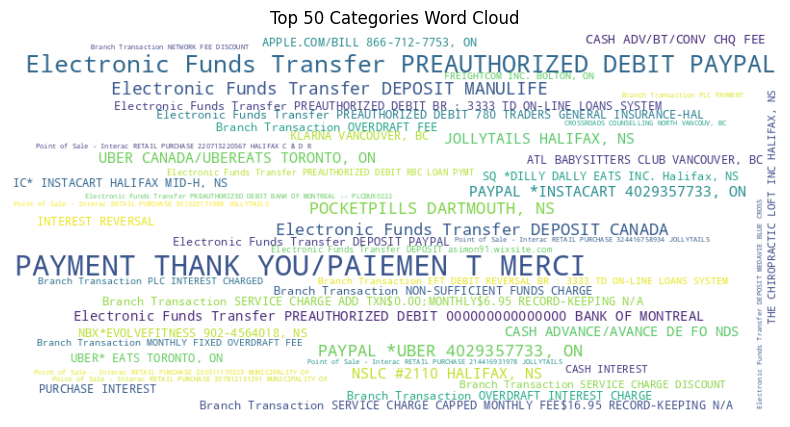

In [ ]:
# Create a dictionary from the top 50 categories and their frequencies
top_50_dict = dict(top_50_categories)

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_50_dict)

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 50 Categories Word Cloud")
plt.show()

#### generate new embeddings and save to fin_embeddings

In [ ]:
# Your existing code for reading and preprocessing the CSV
existing_csv_path = '/content/fin_data_tokens/fin_tokens.csv'
df = pd.read_csv(existing_csv_path)

# Initialize the FinBERT model and tokenizer
model_name = "yiyanghkust/finbert-tone"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)  # Note the change here

# Generate embeddings for each 'Payee' description
embeddings = []

for text in df['Payee']:
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)  # Added max_length
    with torch.no_grad():
        outputs = model(**inputs)
    # Extract the embeddings and average them across the sequence length
    embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().tolist())

# Add the embeddings as a new column to the DataFrame
df['Embeddings'] = embeddings

# Create the output directory if it doesn't exist
output_directory = '/content/fin_embeddings'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Export the DataFrame with the new 'Embeddings' column to a new CSV file
output_csv_path = os.path.join(output_directory, 'findata_embed.csv')
df.to_csv(output_csv_path, index=False)

print(f"Embeddings have been saved to {output_csv_path}")

Embeddings have been saved to /content/fin_embeddings/findata_embed.csv


#### PCA & t-SNE analysis charts & clustering charts

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1578 samples in 0.047s...
[t-SNE] Computed neighbors for 1578 samples in 1.561s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1578
[t-SNE] Computed conditional probabilities for sample 1578 / 1578
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.826950
[t-SNE] KL divergence after 300 iterations: 1.061734


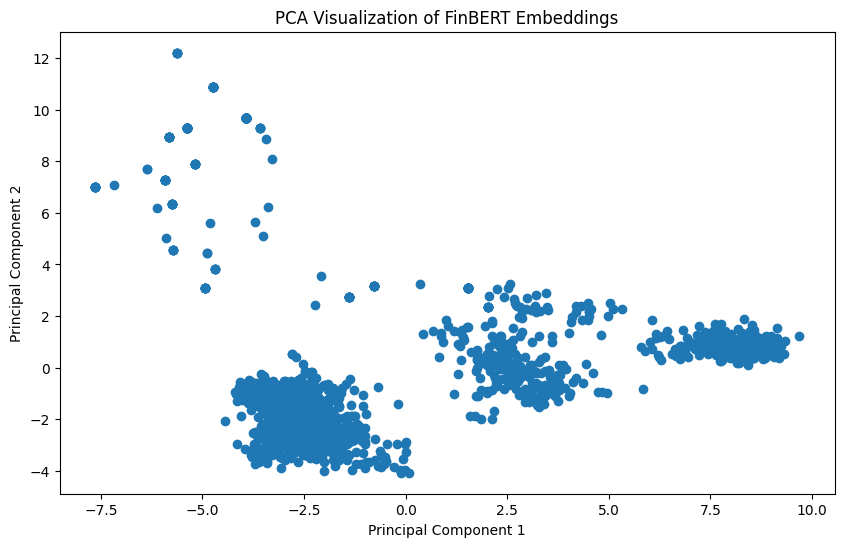

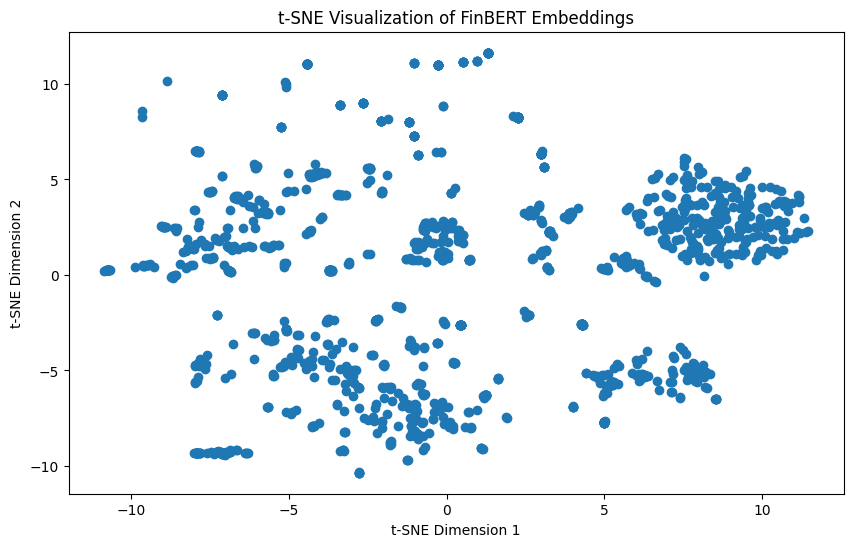

In [ ]:
# Assuming df is your DataFrame and 'Embeddings' is the column with FinBERT embeddings
existing_csv_path = '/content/fin_embeddings/findata_embed.csv'
df = pd.read_csv(existing_csv_path)

# Convert the 'Embeddings' column from string to list of floats
df['Embeddings'] = df['Embeddings'].apply(eval)

# Create a new DataFrame from the 'Embeddings' column
embeddings_df = pd.DataFrame(df['Embeddings'].tolist())

# Perform PCA for 2D visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_df)

# Perform t-SNE for 2D visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_result = tsne.fit_transform(embeddings_df)

# Plotting the PCA result
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.title('PCA Visualization of FinBERT Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Plotting the t-SNE result
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1])
plt.title('t-SNE Visualization of FinBERT Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


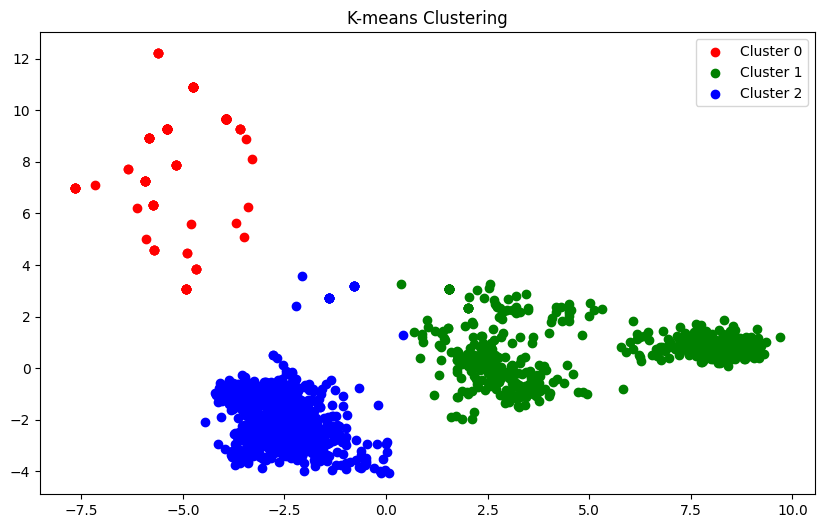

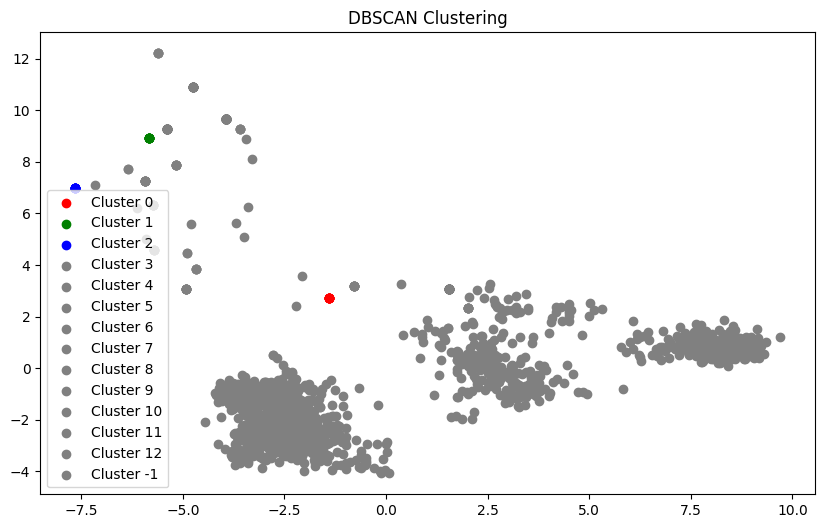

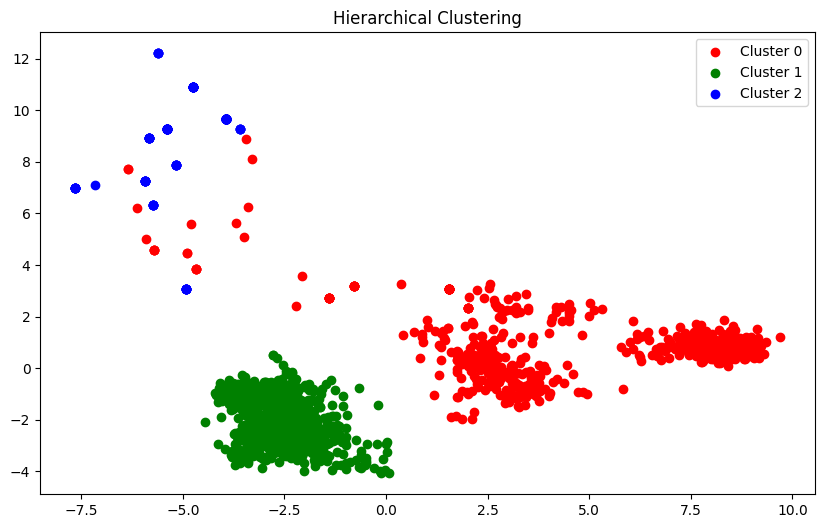

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'Embeddings' is the column with FinBERT embeddings
existing_csv_path = '/content/fin_embeddings/findata_embed.csv'
df = pd.read_csv(existing_csv_path)

# Convert the 'Embeddings' column from string to list of floats
df['Embeddings'] = df['Embeddings'].apply(eval)

# Create a new DataFrame from the 'Embeddings' column
embeddings_df = pd.DataFrame(df['Embeddings'].tolist())

# K-means Clustering
kmeans = KMeans(n_clusters=3)  # You can change the number of clusters
kmeans_labels = kmeans.fit_predict(embeddings_df)
df['KMeans_Labels'] = kmeans_labels

# DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can change eps and min_samples
dbscan_labels = dbscan.fit_predict(embeddings_df)
df['DBSCAN_Labels'] = dbscan_labels

# Hierarchical Clustering
agg_clustering = AgglomerativeClustering(n_clusters=3)  # You can change the number of clusters
agg_labels = agg_clustering.fit_predict(embeddings_df)
df['Agg_Labels'] = agg_labels

# Visualize the clusters using PCA (you can also use t-SNE)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings_df)

# Create a color map
colors = {0: 'red', 1: 'green', 2: 'blue'}

# Plot K-means clusters
plt.figure(figsize=(10, 6))
for label in set(kmeans_labels):
    color = colors[label]
    indices = [i for i, l in enumerate(kmeans_labels) if l == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=color, label=f'Cluster {label}')
plt.title('K-means Clustering')
plt.legend()
plt.show()

# Plot DBSCAN clusters
plt.figure(figsize=(10, 6))
for label in set(dbscan_labels):
    color = colors.get(label, 'gray')  # Use gray for noise points
    indices = [i for i, l in enumerate(dbscan_labels) if l == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=color, label=f'Cluster {label}')
plt.title('DBSCAN Clustering')
plt.legend()
plt.show()

# Plot Hierarchical clusters
plt.figure(figsize=(10, 6))
for label in set(agg_labels):
    color = colors[label]
    indices = [i for i, l in enumerate(agg_labels) if l == label]
    plt.scatter(pca_result[indices, 0], pca_result[indices, 1], c=color, label=f'Cluster {label}')
plt.title('Hierarchical Clustering')
plt.legend()
plt.show()

# Save the DataFrame with cluster labels
df.to_csv('/content/finbed_analysis/finbed_clusters.csv', index=False)

In [ ]:
# Extracting 'Payee' descriptions for all clusters in K-means
output_directory = '/content/fin_cluster_kmeans'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

for i in range(3):  # Assuming you have 3 clusters
    cluster_data = df[df['KMeans_Labels'] == i]['Payee']
    print(f"Textual references in Cluster {i}:\n", cluster_data)

    # Save to a separate CSV file for each cluster
    output_csv_path = os.path.join(output_directory, f'kmeans_cluster_{i}.csv')
    cluster_data.to_csv(output_csv_path, index=False)
    print(f"Cluster {i} data has been saved to {output_csv_path}")

In [ ]:
# Create an output directory for DBSCAN cluster analysis
output_directory_dbscan = '/content/fin_cluster_dbscan'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory_dbscan):
    os.makedirs(output_directory_dbscan)

# Extracting 'Payee' descriptions for all unique DBSCAN labels (including noise labeled as -1)
unique_dbscan_labels = df['DBSCAN_Labels'].unique()

for label in unique_dbscan_labels:
    cluster_data = df[df['DBSCAN_Labels'] == label]['Payee']
    print(f"Textual references in DBSCAN Label {label}:\n", cluster_data)

    # Save to a separate CSV file for each DBSCAN label
    output_csv_path = os.path.join(output_directory_dbscan, f'dbscan_label_{label}.csv')
    cluster_data.to_csv(output_csv_path, index=False)
    print(f"DBSCAN Label {label} data has been saved to {output_csv_path}")

In [ ]:
# Create an output directory for Hierarchical cluster analysis
output_directory_hierarchical = '/content/fin_cluster_hierarchy'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory_hierarchical):
    os.makedirs(output_directory_hierarchical)

# Extracting 'Payee' descriptions for all clusters in Hierarchical Clustering
for i in range(3):  # Assuming you have 3 clusters
    cluster_data = df[df['Agg_Labels'] == i]['Payee']
    print(f"Textual references in Hierarchical Cluster {i}:\n", cluster_data)

    # Save to a separate CSV file for each Hierarchical cluster
    output_csv_path = os.path.join(output_directory_hierarchical, f'hierarchical_cluster_{i}.csv')
    cluster_data.to_csv(output_csv_path, index=False)
    print(f"Hierarchical Cluster {i} data has been saved to {output_csv_path}")

#### advanced analytics

In [ ]:
import pandas as pd
from collections import Counter

# Assuming df is your DataFrame with cluster labels
existing_csv_path = '/content/finbed_analysis/finbed_clusters.csv'
df = pd.read_csv(existing_csv_path)

# Create an output directory for the analysis
output_directory_analysis = '/content/fin_cluster_analysis'

# Create the output directory if it doesn't exist
if not os.path.exists(output_directory_analysis):
    os.makedirs(output_directory_analysis)

# Function to analyze each cluster
def analyze_cluster(cluster_data, cluster_type, cluster_label):
    # Count the frequency of each unique 'Payee' description
    payee_counter = Counter(cluster_data)

    # Identify the top 5 most frequent 'Payee' descriptions
    top_5_payees = payee_counter.most_common(5)

    # Summary
    print(f"Analysis for {cluster_type} Cluster {cluster_label}:")
    print("Top 5 most frequent Payee descriptions:")
    for payee, count in top_5_payees:
        print(f"{payee}: {count} transactions")

    # Save the analysis to a text file
    with open(f"{output_directory_analysis}/{cluster_type}_cluster_{cluster_label}_analysis.txt", "w") as f:
        f.write(f"Analysis for {cluster_type} Cluster {cluster_label}:\n")
        f.write("Top 5 most frequent Payee descriptions:\n")
        for payee, count in top_5_payees:
            f.write(f"{payee}: {count} transactions\n")

    print(f"Analysis saved to {output_directory_analysis}/{cluster_type}_cluster_{cluster_label}_analysis.txt")

# Analyze K-means clusters
for i in range(3):  # Assuming you have 3 K-means clusters
    cluster_data = df[df['KMeans_Labels'] == i]['Payee']
    analyze_cluster(cluster_data, "KMeans", i)

# Analyze DBSCAN clusters
unique_dbscan_labels = df['DBSCAN_Labels'].unique()
for label in unique_dbscan_labels:
    cluster_data = df[df['DBSCAN_Labels'] == label]['Payee']
    analyze_cluster(cluster_data, "DBSCAN", label)

# Analyze Hierarchical clusters
for i in range(3):  # Assuming you have 3 Hierarchical clusters
    cluster_data = df[df['Agg_Labels'] == i]['Payee']
    analyze_cluster(cluster_data, "Hierarchical", i)

#### zip & download

In [ ]:
import shutil
shutil.make_archive("/content/fin_cluster_analysis", 'zip', "/content/fin_cluster_analysis")

from google.colab import files
files.download('/content/fin_cluster_analysis.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>